## Developing a minimally linearized B-Spline approx from scratch

To improve my understanding of how all this works

Importing a few libraries...

In [1]:
import matplotlib.pyplot as plt
import torch

### B-Spline Approximation

First, let's approximate a function using a B-spline without linearizing anything

We need to:

- Create a grid of control points
- Define a function to approximate
- Calculate basis functions for the spline order
- Calculate basis function coefficients

In [2]:
#Analagous to Torch linspace for testing
def gen_range(lower, upper, length):
    return [lower + x*(upper-lower)/length for x in range(length)]

In [3]:
#Cox-De Boor Recursion function
def CDBR(grid, i, k, x):
    if (k == 0):
        if (grid[i] <= x and x < grid[i+1]):
            return 1
        else:
            return 0
    else:
        base1 = ((x-grid[i])/(grid[i+k]-grid[i]))*CDBR(grid, i, k-1, x)
        base2 = ((grid[i+k+1]-x)/(grid[i+k+1]-grid[i+1]))*CDBR(grid,i+1,k-1, x)
        return base1+base2

In [4]:
#Evaluate basis function
def eval_basis(grid, idx, k, x):
    x_out = []

    for x_ in x:
        x_out.append(CDBR(grid, idx, k, x_))

    return x_out

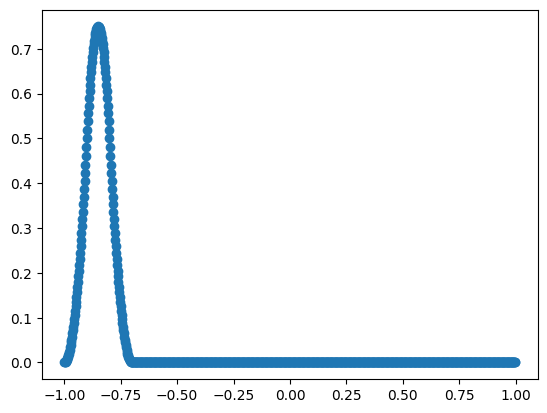

In [5]:
#Define B-spline order
k = 2
#Define number of control points
ctrl_pts = 20
#Define space length
space_len = 1000

#Creating ten control points
grid = gen_range(-1, 1, ctrl_pts)

#Defining the points that will compose the B-spline
x = gen_range(-1, 1, space_len)

#Evaluate set of basis functions
basis_funcs = []
for i in range(ctrl_pts-k-1):
    basis_funcs.append(eval_basis(grid, i, k, x))

#Proving functionality of feature generation (only showing first feature)
#spline = eval_basis(grid, k, x)
plt.scatter(x, basis_funcs[0])
plt.show()

Basis functions look good, now to calculate coefficients and do linear combo

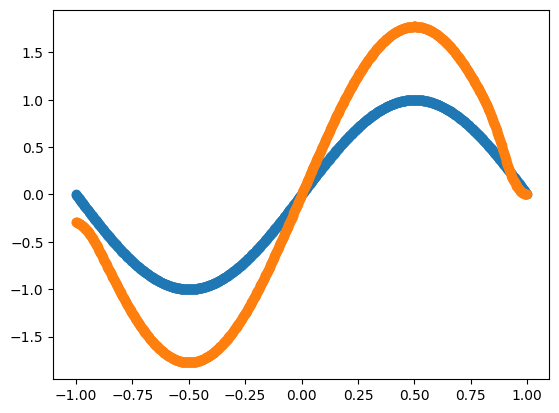

In [20]:
#Function to approximate
fn = lambda x: torch.sin(torch.pi*x)

#Calculate linear combo coefficients by doing least squares on the eval function and the basis functions
coeffs = []
for basis in basis_funcs:
    basis_T = torch.Tensor(basis)
    x_T = torch.Tensor(x)
    coeffs.append(torch.linalg.lstsq(basis_T.unsqueeze(1), fn(x_T)).solution)

#Perform linear combo
spline = [0 for _ in range(space_len)]
for i, basis in enumerate(basis_funcs):
    for j, _ in enumerate(basis):
        spline[j] += basis[j]*coeffs[i]

plt.scatter(x, fn(x_T))
plt.scatter(x, spline)

It's alright, but we could do with some grid extension

In [7]:
def grid_extend(grid, k):
    grid_out = []
    interval_length = grid[1]-grid[0]
    for i in range(k):
        grid_out.append(grid[0]-(k-i)*interval_length)
    grid_out += grid[:]
    for i in range(k):
        grid_out.append(grid_out[-1]+interval_length)
    return grid_out

#Evaluate basis function
def eval_basis_extend(grid, idx, k, x):
    x_out = []
    grid_ = grid_extend(grid, k)
    
    for x_ in x:
        x_out.append(CDBR(grid_, idx, k, x_))

    return x_out


And do it all again but with grid extension this time

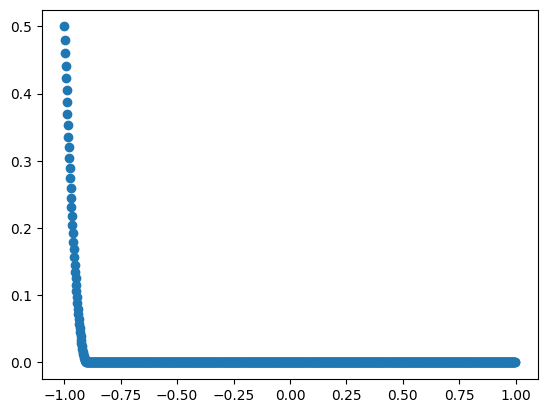

In [10]:
#Define B-spline order
k = 2
#Define number of control points
ctrl_pts = 20
#Define space length
space_len = 1000

#Creating ten control points
grid = gen_range(-1, 1, ctrl_pts)

#Defining the points that will compose the B-spline
x = gen_range(-1, 1, space_len)

#Evaluate set of basis functions
basis_funcs = []
for i in range(ctrl_pts):
    basis_funcs.append(eval_basis_extend(grid, i, k, x))

#Proving functionality of feature generation (only showing first feature)
#spline = eval_basis(grid, k, x)
plt.scatter(x, basis_funcs[0])
plt.show()

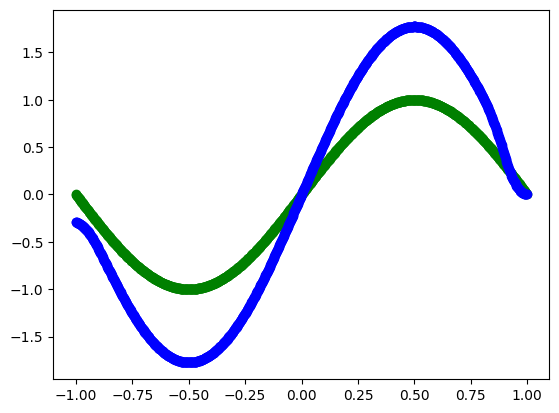

In [18]:
#Function to approximate
fn = lambda x: torch.sin(torch.pi*x)

#Calculate linear combo coefficients by doing least squares on the eval function and the basis functions
coeffs = []
for basis in basis_funcs:
    basis_T = torch.Tensor(basis)
    x_T = torch.Tensor(x)
    coeffs.append(torch.linalg.lstsq(basis_T.unsqueeze(1), fn(x_T)).solution)

#Perform linear combo
spline = [0 for _ in range(space_len)]
for i, basis in enumerate(basis_funcs):
    for j, _ in enumerate(basis):
        spline[j] += basis[j]*coeffs[i]

plt.scatter(x, fn(x_T), color="green")
plt.scatter(x, spline, color="blue")

Much better, but the weird implementation is showing. Need to linearize this before moving on, not making the full KAN this time because it's already really bad